## Problem Discription:
In this project, you will use deep learning to predict forest cover type (the most common kind of tree cover) based only on \
cartographic variables. The actual forest cover type for a given 30 x 30 meter cell was determined from US Forest Service (USFS)\
Region 2 Resource Information System data. The covertypes are the following:
- Spruce/Fir
- Lodgepole Pine
- Ponderosa Pine
- Cottonwood/Willow
- Aspen
- Douglas-fir
- Krummholz

## Project Objectives:
- Develop one or more classifiers for this multi-class classification problem.
- Use TensorFlow with Keras to build my classifier(s). 
- Use my knowledge of hyperparameter tuning to improve the performance of my model(s).
- Test and analyse performance.
- Create clean and modular code.

## Preprocess and explore the dataset

In [1]:
import pandas as pd
import tensorflow as tf
import keras
import numpy as np
import os


from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [2]:
data_df = pd.read_csv('dlsp-portfolio-solution-code/cover_data.csv')
data_df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,class
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


## Type Distributions- Visualising with Histogram using Matplotlib

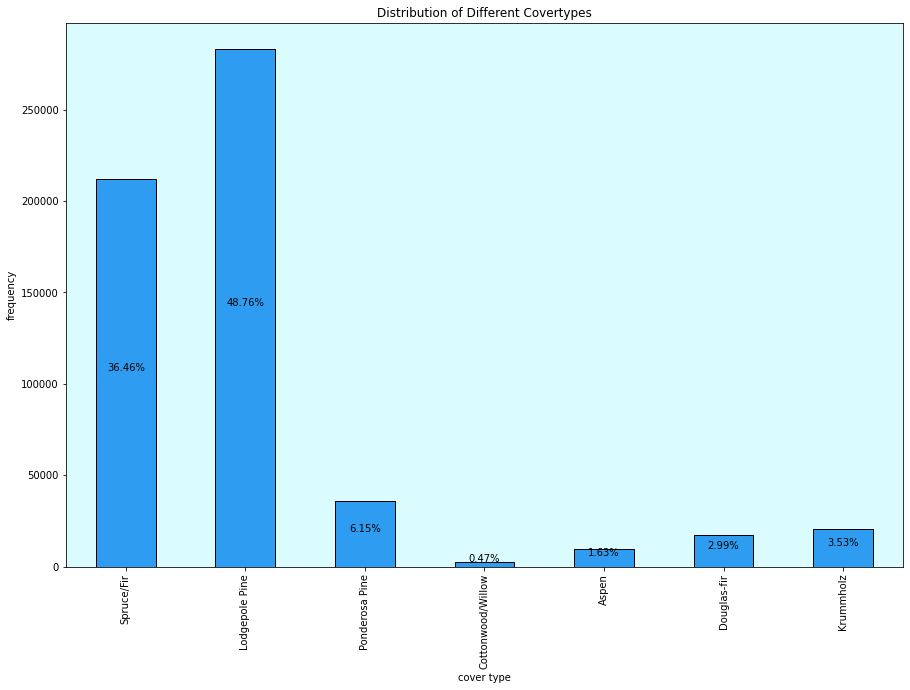

In [3]:
# create a list of our conditions
conditions = [
    data_df['class'] == 1,
    data_df['class'] == 2,
    data_df['class'] == 3,
    data_df['class'] == 4,
    data_df['class'] == 5,
    data_df['class'] == 6,
    data_df['class'] == 7
]

# create a list of the values we want to assign for each condition
values = [
    'Spruce/Fir',
    'Lodgepole Pine',
    'Ponderosa Pine',
    'Cottonwood/Willow',
    'Aspen',
    'Douglas-fir',
    'Krummholz'
]

# create a new column and use np.select to assign values to it using our lists as arguments
data_df['cover_type'] = np.select(conditions, values)


fig = plt.subplots(1, 1, figsize = (15, 10))

# Visualisation
ax = data_df['cover_type'].value_counts().loc[values].plot(kind = 'bar', color = '#2E9CF0', edgecolor = '#000000')
ax.set_title('Distribution of Different Covertypes')
ax.set_xlabel('cover type')
ax.set_ylabel('frequency')
ax.set_facecolor('#DAFCFE')


heights = [covertype.get_height() for covertype in ax.patches]
height_max = max(heights)
total_height = sum(heights)

for covertype in ax.patches:
    percentage = covertype.get_height() / total_height
    height = covertype.get_height() 
    ax.text(covertype.get_x() + covertype.get_width() / 2, 
            covertype.get_y() + height / 2,
            "%.2f%%" %(percentage * 100),
            color = '#000000',
            ha = 'center', 
            va = 'bottom')

# Save before displaying
plt.savefig('distribution of cover types.png')

plt.show()

In [4]:
covertype0 = ax.patches[0]
covertype0.get_height()
max(heights)

data_df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,class,cover_type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,5,Aspen
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,5,Aspen
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,2,Lodgepole Pine
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,2,Lodgepole Pine
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,5,Aspen


## Preprocessing data

In [5]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Extract only values from the raw dataframe- to remove unncessary indices
data = data_df.values
X, y = data[:, :-2], data[:, -2]



print(y[:5])
# One-hot encode targets
y = to_categorical(y)

# Split the raw data into training and test data
trainX, testX, trainy, testy = train_test_split(X, y, test_size = .3, stratify = y, random_state = 30)
#print(trainX)
#print('trainX: ', trainX.shape) # (406708, 54)
#print(trainy)
#print('trainy: ', trainy.shape) # (406708, 8)

# Normalise feature data
scaler = StandardScaler()
trainX_normalised = scaler.fit_transform(trainX)
testX_normalised = scaler.transform(testX)


print('trainy: ', trainy.shape)
print(trainy[:5])

# Check number of classes
print(trainy.shape[0]) # 8


[5 5 2 2 5]
trainy:  (406708, 8)
[[0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]]
406708


In [6]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


def preprocess_data(data_df):
    
    # Extract only values from the raw dataframe- to remove unncessary indices
    data = data_df.values
    X, y = data[:, :-2], data[:, -2]
    
    # One-hot encode targets: for multi-class classification
    y = to_categorical(y)
    
    # Split the raw data into training and test data
    trainX, testX, trainy, testy = train_test_split(X, y, test_size = .3, stratify = y, random_state = 30)
    
    # Normalise feature data
    scaler = StandardScaler()
    trainX_normalised = scaler.fit_transform(trainX)
    testX_normalised = scaler.transform(testX)
    
    return trainX_normalised, testX_normalised, trainy, testy

In [7]:
print('testX_normalised:', type(testX_normalised))
print(testX_normalised.shape)
print(testX_normalised)
print('\r\n')
print('testy:', type(testy))
print(testy.shape)
print(testy)

testX_normalised: <class 'numpy.ndarray'>
(174304, 54)
[[ 0.1595821  -1.31741865 -0.14804733 ... -0.16495941 -0.15615291
  -0.12379701]
 [ 1.11977269  1.54312682  0.38574373 ... -0.16495941 -0.15615291
  -0.12379701]
 [-1.65371464 -0.19107887  0.78608703 ... -0.16495941 -0.15615291
  -0.12379701]
 ...
 [ 0.14887365  0.51511829 -0.54839062 ... -0.16495941 -0.15615291
  -0.12379701]
 [ 0.45584908 -1.15651297  0.1188482  ... -0.16495941 -0.15615291
  -0.12379701]
 [-0.57216166 -0.73637035  1.85366915 ... -0.16495941 -0.15615291
  -0.12379701]]


testy: <class 'numpy.ndarray'>
(174304, 8)
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


## Build our multi-class classifier using deep network

Achitecture coutersy to Syed Ali Hussain's thesis: [*Forest Cover type prediction using Deep Neural Network*](http://users.cecs.anu.edu.au/~Tom.Gedeon/conf/ABCs2018/paper/ABCs2018_paper_69.pdf)

In [8]:
from tensorflow.keras.layers import InputLayer, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import AUC, CategoricalAccuracy
from tensorflow.keras.optimizers import Adam, SGD

cce = 'categorical_crossentropy' # for one-hot encoded target data
scce = 'sparse_categorical_crossentropy' # for labelled target data
    

# model containing 1 hidden layer only
def design_2_layer_classifier(n_features, n_classes):
    
    model = Sequential(name = 'covertype_2_layered_classifier')
    
    model.add(InputLayer(input_shape = (n_features, )))
    model.add(Dense(110, activation = 'relu'))
    # model.add(Dropout(.3)) # Dropout layer is not needed for small-architectured model
    model.add(Dense(n_classes, activation = 'softmax')) # output layer: #(classes) = number of uniquelabels
    
    # tuning hyperparameters
    opt = SGD(learning_rate = 1e-3, momentum = 0.5)
    
    model.compile(loss = cce, metrics = ['accuracy'], optimizer = opt)
    
    model.summary()
    
    return model



# model containing 2 hidden layers
def design_3_layer_classifier(n_features, n_classes):
    
    model = Sequential(name = 'covertype_3_layered_classifier')
    
    model.add(Dense(140, input_dim = n_features, activation = 'relu'))
    model.add(Dense(140, activation = 'relu'))
    model.add(Dense(n_classes, activation = 'softmax')) # output layer: #(classes) = number of uniquelabels
    
    # tuning hyperparameters
    opt = SGD(learning_rate = 1e-3, momentum = 0.5)
    
    model.compile(loss = cce, metrics = ['accuracy'], optimizer = 'adam') # Don't ever use Accuracy() as accuracy, use 'accuracy' instead
    
    model.summary()
    
    return model


In [9]:
print(trainX_normalised.shape[1])
print(trainX_normalised.shape)
print(trainy.shape)
print(testy.shape)
print(trainy)

54
(406708, 54)
(406708, 8)
(174304, 8)
[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


## Train the model from scratch

In [10]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold, StratifiedKFold # cross validation
from sklearn.model_selection import cross_val_score


# K-fold cross validation
kf = KFold(n_splits = 10, random_state = 30, shuffle = True)

# n_features (54 features)
n_features = trainX_normalised.shape[1]

# n_classes (8 categories)- check if trainy is categorical or not
if len(trainy.shape) == 1: # direct class
    n_classes = max(trainy) + 1  
elif len(trainy.shape) == 2:  # is categorical
    n_classes = trainy.shape[1]
else:
    pass


clf = design_3_layer_classifier(n_features, n_classes)
#clf = build_my_classifier(n_features, n_classes)


# Set an early stopping callback
es = EarlyStopping(monitor = 'val_accuracy', mode = 'max', verbose = 1, patience = 20)

# Train the model without cross validation
print('[INFO] Fitting model...')

# Option 1: Train without early stopping- DEBUG from this pt on
#history = clf.fit(trainX_normalised, trainy, validation_split = .25, epochs = 1000, batch_size = 1024, verbose = 1)

# Option 2: Train with early stopping
history = clf.fit(trainX_normalised, trainy, validation_split = .25, epochs = 1000, batch_size = 1024, callbacks = [es], verbose = 1)

# Train the model with cross validation
#print('[INFO] Scoring model with cross validation...')
#scores = cross_val_score(clf, trainX_normalised, trainy, scoring = 'accuracy', cv = kf, n_jobs = -1)


# Evaluate model
print('[INFO] Evaluating model without cross validation...')
score = clf.evaluate(testX_normalised, testy, batch_size = 512, verbose = 1)

Model: "covertype_3_layered_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 140)               7700      
_________________________________________________________________
dense_1 (Dense)              (None, 140)               19740     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1128      
Total params: 28,568
Trainable params: 28,568
Non-trainable params: 0
_________________________________________________________________
[INFO] Fitting model...
Epoch 1/1000
298/298 [==============================] - 1s 4ms/step - loss: 0.6954 - accuracy: 0.7179 - val_loss: 0.5814 - val_accuracy: 0.7509
Epoch 2/1000
298/298 [==============================] - 1s 4ms/step - loss: 0.5471 - accuracy: 0.7667 - val_loss: 0.5196 - val_accuracy: 0.7781
Epoch 3/1000
298/298 [============================

298/298 [==============================] - 1s 4ms/step - loss: 0.2317 - accuracy: 0.9069 - val_loss: 0.2566 - val_accuracy: 0.8967
Epoch 53/1000
298/298 [==============================] - 1s 4ms/step - loss: 0.2308 - accuracy: 0.9072 - val_loss: 0.2524 - val_accuracy: 0.9006
Epoch 54/1000
298/298 [==============================] - 1s 4ms/step - loss: 0.2311 - accuracy: 0.9069 - val_loss: 0.2501 - val_accuracy: 0.9019
Epoch 55/1000
298/298 [==============================] - 1s 4ms/step - loss: 0.2278 - accuracy: 0.9085 - val_loss: 0.2453 - val_accuracy: 0.9028
Epoch 56/1000
298/298 [==============================] - 1s 4ms/step - loss: 0.2265 - accuracy: 0.9093 - val_loss: 0.2484 - val_accuracy: 0.9011
Epoch 57/1000
298/298 [==============================] - 1s 4ms/step - loss: 0.2253 - accuracy: 0.9103 - val_loss: 0.2474 - val_accuracy: 0.9015
Epoch 58/1000
298/298 [==============================] - 1s 4ms/step - loss: 0.2260 - accuracy: 0.9089 - val_loss: 0.2438 - val_accuracy: 0.9032

## Save / Load training history

In [11]:
import os

def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

In [12]:
import pandas as pd

# Creates a folder in the current directory named after the model name       
createFolder('Trained_Models/' + clf.name + '/')


# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# method 1: save to json:  
hist_json_file = 'Trained_Models/' + clf.name + '/history.json' 
with open(hist_json_file, mode = 'w') as f:
    hist_df.to_json(f)

# method 2: save to csv: 
hist_csv_file = 'Trained_Models/' + clf.name + '/history.csv'
with open(hist_csv_file, mode = 'w') as f:
    hist_df.to_csv(f)
    
# method 3: save to npy
np.save('Trained_Models/' + clf.name + '/history.npy',history.history) # save

# history = np.load('Trained_Models/' + clf.name + '/history.npy', allow_pickle = 'TRUE').item() # load

## Save / Load a trained model

In [13]:
from tensorflow.keras.models import load_model

# Save the model trained earlier
clf.save('Trained_Models/' + clf.name )

# Load a pre-trained model
#clf = load_model('Trained_Models/' + clf.name)

# Show architecture of network
clf.summary()


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Trained_Models/covertype_3_layered_classifier\assets
Model: "covertype_3_layered_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 140)               7700      
_________________________________________________________________
dense_1 (Dense)              (None, 140)               19740     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1128      
Total params: 28,568
Trainable params: 28,568
Non-trainable params: 0
_________________________________________________________________


## Display training history

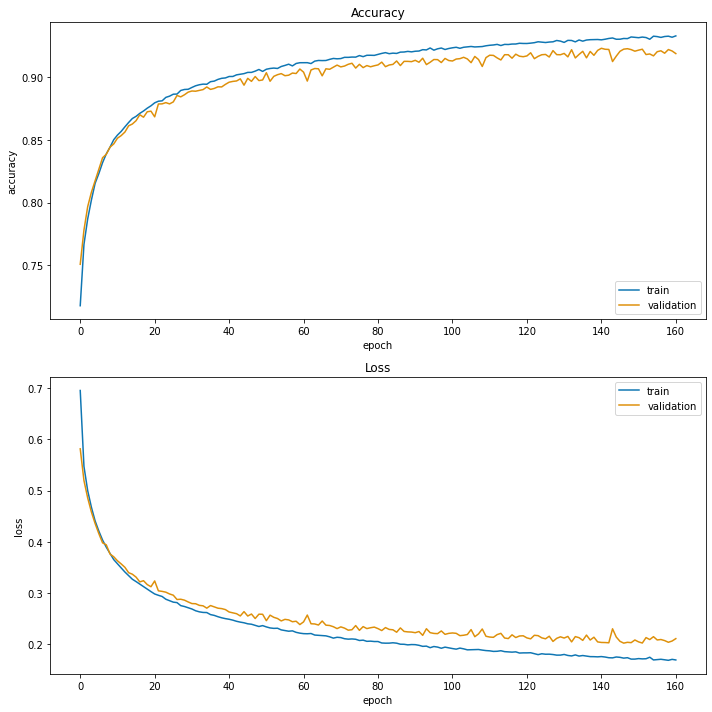

In [17]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(2, 1, figsize = (10, 10))

# Plot training & validation accuracy
axes[0].plot(history.history['accuracy'], color = '#0F76B3', label = 'train')
axes[0].plot(history.history['val_accuracy'], color = '#DE900A', label = 'validation')
axes[0].set_title('Accuracy')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('accuracy')
axes[0].legend(loc = 'lower right')

# Plot training & validation loss function
axes[1].plot(history.history['loss'], color = '#0F76B3', label = 'train')
axes[1].plot(history.history['val_loss'], color = '#DE900A', label = 'validation')
axes[1].set_title('Loss')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('loss')
axes[1].legend(loc = 'upper right')

plt.tight_layout()
plt.show()


fig.savefig('Trained_Models/' + clf.name + '/acc_loss_plot.png')


## Predict by the model

In [15]:
pred_y = clf.predict(testX_normalised, batch_size = 32, verbose = 1)

print('Before conversion...')
print(pred_y) # array of probabilities

# Convert the pred to discrete values
print('After conversion...')
pred_y = np.argmax(pred_y, axis = 1)
print(pred_y) # real label

# Convert testy to real label if necessary
if len(testy.shape) == 2:
    testy = np.argmax(testy, axis = 1)

5447/5447 [==============================] - 5s 1ms/step
Before conversion...
[[8.8529432e-29 9.6587223e-01 3.4127828e-02 ... 0.0000000e+00
  0.0000000e+00 3.4337658e-26]
 [6.3360674e-32 1.0888929e-02 9.8911089e-01 ... 3.1671379e-36
  0.0000000e+00 1.0380990e-07]
 [5.8539500e-19 2.5592531e-06 2.5456774e-04 ... 9.4970595e-08
  5.7927281e-02 2.9586646e-30]
 ...
 [7.4804031e-31 2.2110689e-04 9.9977893e-01 ... 1.2815651e-36
  0.0000000e+00 5.1029889e-36]
 [8.6852948e-16 9.9949205e-01 5.0791487e-04 ... 4.2512301e-21
  1.2577744e-13 1.4065219e-17]
 [4.9896355e-26 4.3030673e-14 1.0000000e+00 ... 2.4865827e-08
  2.9286615e-10 1.1512101e-34]]
After conversion...
[1 2 3 ... 2 1 2]


In [55]:
# testy v.s.pred_y
print('testy:\r\n')
print(testy)

print('pred_y:\r\n')
print(pred_y)

testy:

[1 2 3 ... 2 1 2]
pred_y:

[1 2 3 ... 2 1 2]


## Confusion matrix visualisation

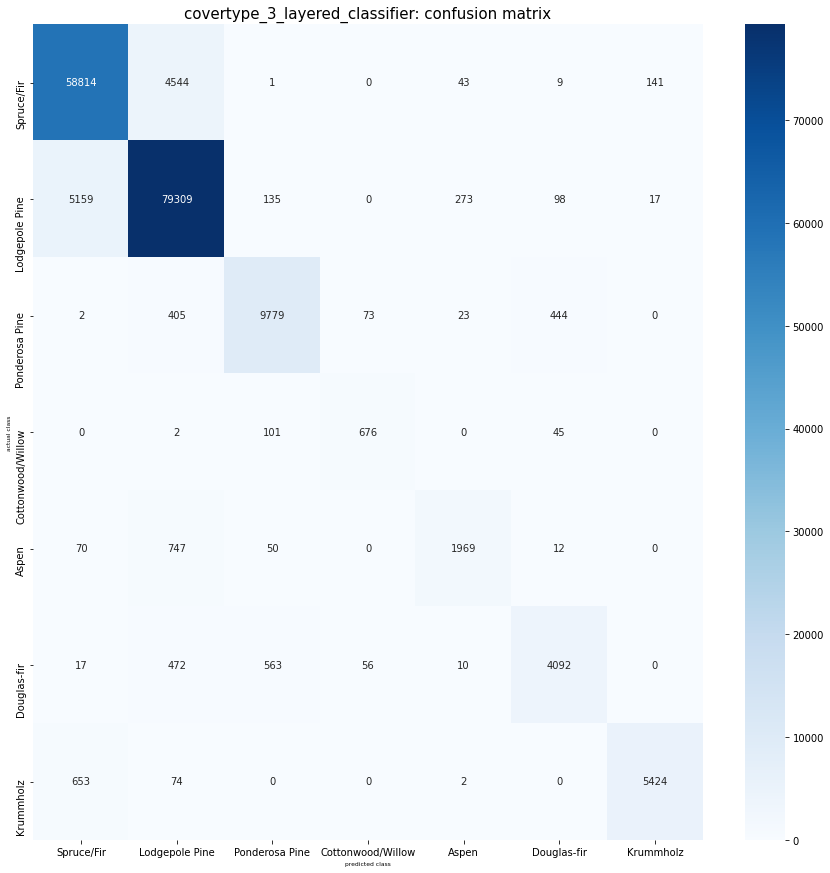

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn

classifier_name = clf.name

# Compute a confusion matrix and plot a heatmap based on that matrix
cm = confusion_matrix(testy, pred_y)
class_names = values

fig, ax = plt.subplots(figsize = (15, 15))

heatmap = seaborn.heatmap(cm, fmt = 'g', cmap = 'Blues', annot = True, ax = ax)
ax.set_xlabel('predicted class', fontsize = 6)
ax.set_ylabel('actual class', fontsize = 6)
ax.set_title(classifier_name + ': confusion matrix', fontsize = 15)
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)

heatmap_fig = heatmap.get_figure()
heatmap_fig.savefig('Trained_Models/' + clf.name + '/confusion_matrix.png')

## Classification report

In [18]:
print(classification_report(testy, pred_y, target_names = values))

                   precision    recall  f1-score   support

       Spruce/Fir       0.91      0.93      0.92     63552
   Lodgepole Pine       0.93      0.93      0.93     84991
   Ponderosa Pine       0.92      0.91      0.92     10726
Cottonwood/Willow       0.84      0.82      0.83       824
            Aspen       0.85      0.69      0.76      2848
      Douglas-fir       0.87      0.79      0.83      5210
        Krummholz       0.97      0.88      0.92      6153

         accuracy                           0.92    174304
        macro avg       0.90      0.85      0.87    174304
     weighted avg       0.92      0.92      0.92    174304

